<a href="https://colab.research.google.com/github/camilorey/material_clases/blob/main/visualizacion_estadisticas_covid19_datosAbiertos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as Pandas
import numpy as NumPy
import seaborn as SeaBorn
import matplotlib.pyplot as PyPlot

Vamos a importar un dataset oficial el COVID-19 en Colombia, desde el portal de datos abiertos. Como no tenemos credenciales del sitio, este solo importará 1000 registros (los primeros mil).

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving covidColombia.csv to covidColombia.csv


In [ ]:
import io
covidDataset = Pandas.read_csv(io.BytesIO(uploaded['covidColombia.csv']))
#vamos a cambiar el nombre de algunas columnas para que sea más fácil de manipular
nuevosNombres = {'ID de caso':'caso_id', 
                 'Fecha de notificación':'fecha_notificacion', 
                 'Codigo DIVIPOLA':'cod_divipola',
                 'Edad':'edad',
                 'Sexo':'sexo',
                 'Tipo':'tipo',
                 'Estado':'estado',
                 'País de procedencia':'procedencia',
                 'Ciudad de ubicación':'ciudad', 
                 'Departamento o Distrito ':'depto',
                 'FIS':'fecha_sintomas',
                 'Fecha de muerte':'fecha_de_muerte',
                 'Fecha diagnostico':'fecha_diagnostico',
                 'Fecha recuperado':'fecha_recuperado',
                 'fecha reporte web':'fecha_reporte_web',
                 'atención':'tipo_atencion'}
covidDataset.rename(columns=nuevosNombres,inplace=True)
#vamos a transformar los campos de fecha en tipos datetime de Pandas
camposFecha = ['fecha_notificacion','fecha_de_muerte','fecha_diagnostico','fecha_recuperado','fecha_reporte_web','fecha_sintomas']
for campo in camposFecha:
  #el errors = 'coerce' obliga a que cualquier campo que no contenga una fecha lo tome como NaT (null)
  covidDataset[campo] = Pandas.to_datetime(covidDataset[campo],errors='coerce')

#vamos a deshacernos de unos campos que no están aportando nada
covidDataset = covidDataset.drop(columns=['caso_id','fecha_reporte_web'])
covidDataset.sample(10)

,fecha_notificacion,cod_divipola,ciudad,depto,tipo_atencion,edad,sexo,tipo,estado,procedencia,fecha_sintomas,fecha_de_muerte,fecha_diagnostico,fecha_recuperado
4510,2020-04-18,50001,Villavicencio,Meta,Casa,38,M,Relacionado,Leve,Colombia,2020-04-08,NaT,2020-04-23,NaT
13836,2020-05-09,47001,Santa Marta,Santa Marta D.T. y C.,Casa,36,F,En estudio,Leve,Colombia,2020-05-08,NaT,2020-05-15,NaT
1546,2020-03-31,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,59,F,En estudio,Leve,Colombia,2020-03-17,NaT,2020-04-06,2020-05-09
13001,2020-05-11,11001,Bogotá D.C.,Bogotá D.C.,Casa,32,F,En estudio,Leve,Colombia,2020-05-10,NaT,2020-05-14,NaT
7749,2020-05-01,13001,Cartagena de Indias,Cartagena D.T. y C.,Casa,28,F,En estudio,Leve,Colombia,2020-04-28,NaT,2020-05-04,NaT
8897,2020-05-01,11001,Bogotá D.C.,Bogotá D.C.,Hospital,44,M,Relacionado,Moderado,Colombia,2020-04-25,NaT,2020-05-06,NaT
2198,2020-03-31,76364,Jamundí,Valle del Cauca,Recuperado,50,F,Importado,Leve,Reino Unido,2020-03-16,NaT,2020-04-09,2020-05-09
13948,2020-05-08,8520,Palmar de Varela,Atlántico,Casa,90,F,En estudio,Leve,Colombia,2020-05-06,NaT,2020-05-15,NaT
2037,2020-03-31,76001,Cali,Valle del Cauca,Recuperado,31,M,En estudio,Leve,Colombia,2020-03-23,NaT,2020-04-08,2020-04-19
13785,2020-05-07,8001,Barranquilla,Barranquilla D.E.,Hospital,68,M,En estudio,Moderado,Colombia,2020-05-07,NaT,2020-05-15,NaT


Ahora, vamos a calcular la duración de la enfermedad como la diferencia entre la fecha desde la aparición de los síntomas hasta la resolución (o bien recuperado o bien fallecido). 

Notemos que tanto los enfermos van a ser considerados enfermos hasta hoy, mientras que los asintomáticos tendrán un NaN en esa casilla.

In [ ]:
def diasEnfermo(row):
  if row['tipo_atencion'] == 'Recuperado':
    return (row['fecha_recuperado']-row['fecha_sintomas']).days
  elif row['tipo_atencion'] =='Fallecido':
    return (row['fecha_de_muerte']-row['fecha_sintomas']).days
  else:
    return (Pandas.to_datetime('today')-row['fecha_sintomas']).days

covidDataset['dias_enfermo'] = covidDataset.apply(lambda row: diasEnfermo(row),axis=1)
covidDataset.sample(10)

,fecha_notificacion,cod_divipola,ciudad,depto,tipo_atencion,edad,sexo,tipo,estado,procedencia,fecha_sintomas,fecha_de_muerte,fecha_diagnostico,fecha_recuperado,dias_enfermo
12484,2020-05-07,91001,Leticia,Amazonas,Casa,27,M,En estudio,Leve,Colombia,2020-05-04,NaT,2020-05-13,NaT,14.0
699,2020-03-28,66001,Pereira,Risaralda,Recuperado,45,F,Importado,Asintomático,España,NaT,NaT,2020-03-29,2020-04-04,NaN
3662,2020-04-16,66170,Dosquebradas,Risaralda,Recuperado,33,F,Relacionado,Leve,Colombia,2020-04-16,NaT,2020-04-19,2020-04-29,13.0
9309,2020-04-30,76001,Cali,Valle del Cauca,Casa,76,F,En estudio,Leve,Colombia,2020-04-24,NaT,2020-05-07,NaT,24.0
4319,2020-04-16,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,46,F,En estudio,Leve,Colombia,2020-04-06,NaT,2020-04-22,2020-05-05,29.0
3117,2020-04-10,20770,San Martín,Cesar,Fallecido,39,F,En estudio,Fallecido,Colombia,2020-04-02,2020-04-27,2020-04-16,NaT,25.0
6853,2020-04-20,11001,Bogotá D.C.,Bogotá D.C.,Hospital,44,M,Relacionado,Moderado,Colombia,2020-04-18,NaT,2020-05-01,NaT,30.0
9813,2020-05-02,11001,Bogotá D.C.,Bogotá D.C.,Casa,27,M,Relacionado,Leve,Colombia,2020-05-02,NaT,2020-05-08,NaT,16.0
8065,2020-05-05,50001,Villavicencio,Meta,Casa,47,M,Relacionado,Asintomático,Colombia,NaT,NaT,2020-05-05,NaT,NaN
12417,2020-05-06,8001,Barranquilla,Barranquilla D.E.,Casa,29,F,En estudio,Leve,Colombia,2020-05-02,NaT,2020-05-13,NaT,16.0


De igual modo, podemos agregar dos variables numéricas, el día cuando comienzan a desarrollar síntomas y los días que pasan desde la notificación hasta el diagnóstico. En este bloque también corregimos los campos de estado y tipo.

In [ ]:
covidDataset['dias_para_diagnostico'] =covidDataset['fecha_diagnostico'] - covidDataset['fecha_notificacion']
covidDataset['dias_para_diagnostico'] = covidDataset['dias_para_diagnostico'].apply(lambda x: x.days)
covidDataset['dias_para_sintomas'] = covidDataset['fecha_diagnostico']-covidDataset['fecha_sintomas']
covidDataset['dias_para_sintomas'] = covidDataset['dias_para_sintomas'].apply(lambda x: x.days)
#corregimos el dataset, el campo estado tiene LEVE leve y Leve
covidDataset['estado'] = covidDataset['estado'].apply(lambda x: str(x).title())
covidDataset = covidDataset[covidDataset['estado'] != 'Nan']
#corregimos el dataset el campo tipo tiene Estudio, En Estudio y En estudiuo
def corregirTipo(campo):
  if campo=='En estudiuo' or campo =='Estudio' or campo=='En estudio':
    return 'En Estudio'
  else:
    return campo
covidDataset['tipo'] = covidDataset['tipo'].apply(lambda x: corregirTipo(x))
covidDataset['tipo'].value_counts()

En Estudio     9842
Relacionado    4241
Importado       841
Name: tipo, dtype: int64

Ahora podemos hacer un histograma de los días enfermos dependiendo del tipo. 

Vamos a poner en rojo los fallecidos, azul los recuperados y verde los que todavía están enfermos.

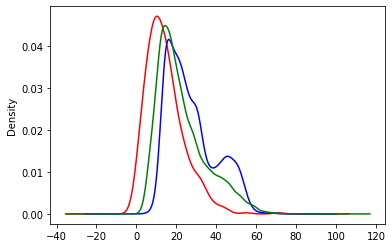

In [ ]:
covidDataset.loc[covidDataset['tipo_atencion']=='Fallecido']['dias_enfermo'].plot.kde(color='red')
covidDataset.loc[covidDataset['tipo_atencion']=='Recuperado']['dias_enfermo'].plot.kde(color='blue')
covidDataset.loc[(covidDataset['tipo_atencion']!='Fallecido') & (covidDataset['tipo_atencion']!='Recuperado')]['dias_enfermo'].plot.kde(color='green')


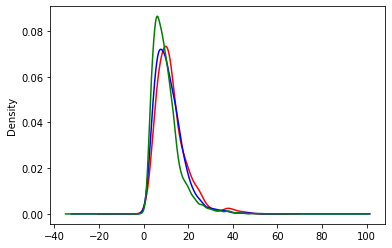

In [ ]:
covidDataset.loc[covidDataset['tipo_atencion']=='Fallecido']['dias_para_sintomas'].plot.kde(color='red')
covidDataset.loc[covidDataset['tipo_atencion']=='Recuperado']['dias_para_sintomas'].plot.kde(color='blue')
covidDataset.loc[(covidDataset['tipo_atencion']!='Fallecido') & (covidDataset['tipo_atencion']!='Recuperado')]['dias_para_sintomas'].plot.kde(color='green')

También podemos ver cómo se distribuyen las edades dependiendo de si están recuperados, fallecidos o enfermos en el siguiente histograma.

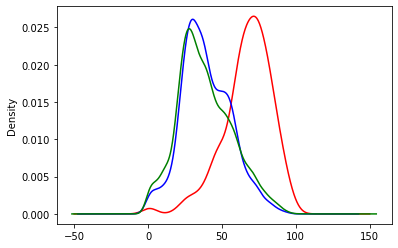

In [ ]:
covidDataset.loc[covidDataset['tipo_atencion']=='Fallecido']['edad'].plot.kde(color='red')
covidDataset.loc[covidDataset['tipo_atencion']=='Recuperado']['edad'].plot.kde(color='blue')
covidDataset.loc[(covidDataset['tipo_atencion']!='Fallecido') & (covidDataset['tipo_atencion']!='Recuperado')]['edad'].plot.kde(color='green')

Con estas dos variables numéricas, podemos hacer un pair-plot para ver cómo es la distribución de fallecidos, recuperados y enfermos con respecto a los días que duraron enfermos (hasta que se recuperan o mueren) y los días que tardaron en desarrollar síntomas. 

Aquí estamos tomando como variable de clasificación el tipo de atención que recibieron (en casa, fallecido, hospital, UCI o recuperado)

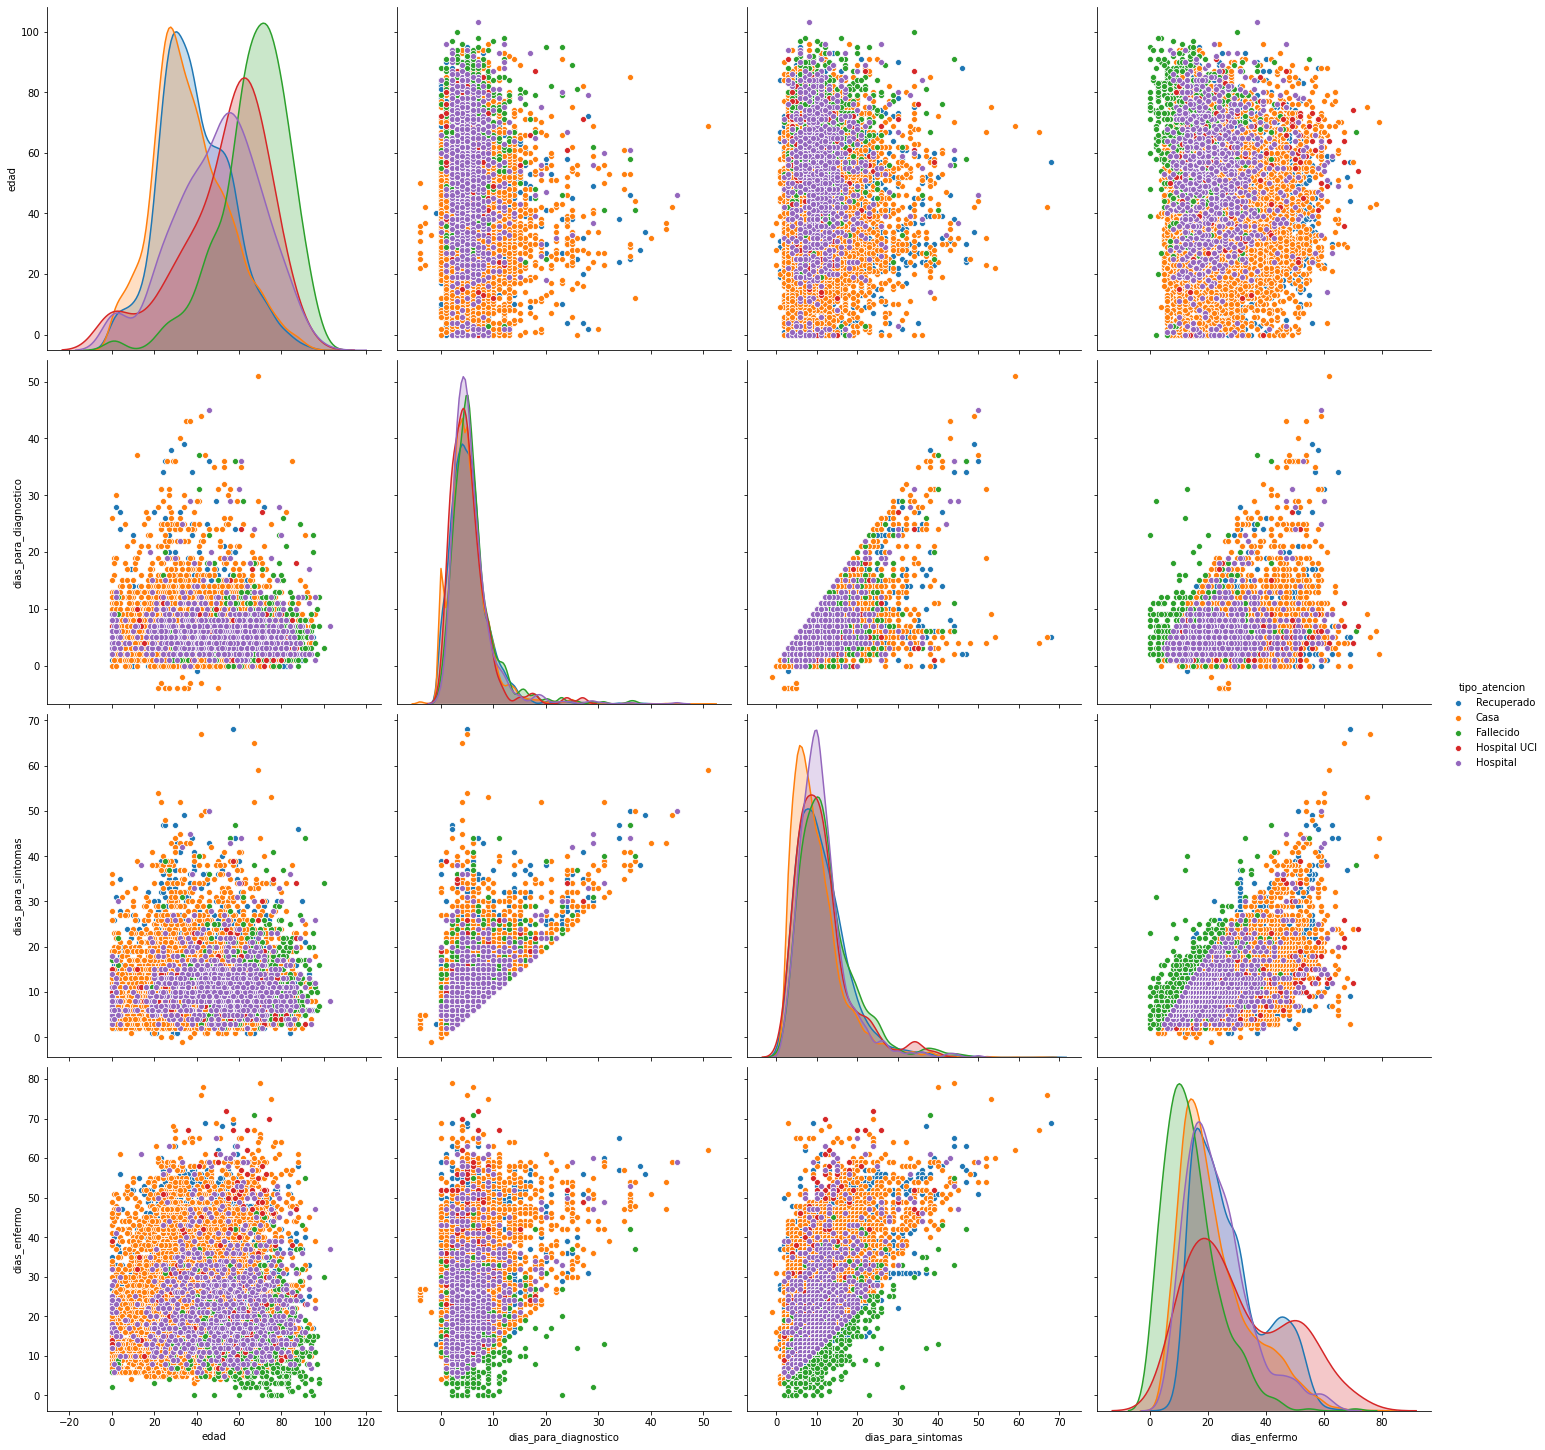

In [ ]:
SeaBorn.pairplot(data=covidDataset[['edad','dias_para_diagnostico','dias_para_sintomas','dias_enfermo','tipo_atencion']],hue='tipo_atencion',height=5)

Ahora podemos ver esto en términos de distribuciones sobre los días que hemos definido para todo el Dataset.

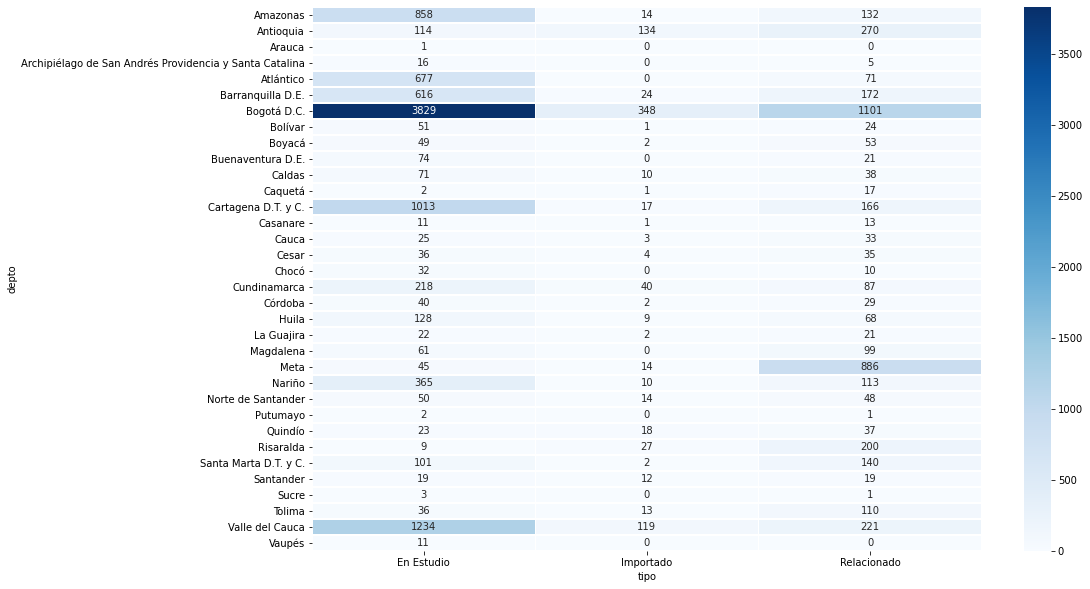

In [ ]:
tipoDepto_contin = Pandas.crosstab(covidDataset['depto'],covidDataset['tipo'])
PyPlot.figure(figsize=(15,10))
SeaBorn.heatmap(tipoDepto_contin,xticklabels=tipoDepto_contin.columns,yticklabels=tipoDepto_contin.index,cmap="Blues",annot=True,fmt='d',linewidths=0.5)

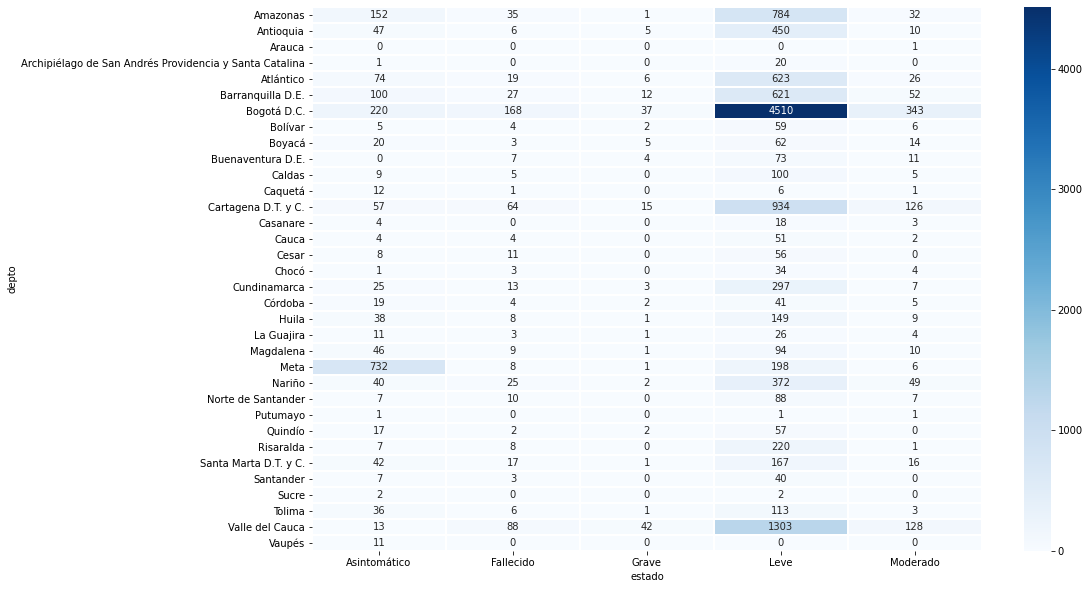

In [ ]:
estadoDepto_contin = Pandas.crosstab(covidDataset['depto'],covidDataset['estado'])
PyPlot.figure(figsize=(15,10))
SeaBorn.heatmap(estadoDepto_contin,xticklabels=estadoDepto_contin.columns,yticklabels=estadoDepto_contin.index,cmap="Blues",annot=True,fmt='d',linewidths=0.5)


Vamos a hacer una tabla pivote para resumir el promedio de los días que hemos coleccionado. Notemos que una tabla pivote es un DataFrame. Vamos a convertirlo en un Pandas DataFrame.

In [ ]:
diasPivot = Pandas.pivot_table(covidDataset,values=['dias_para_diagnostico','dias_para_sintomas','dias_enfermo'],index=['depto','ciudad'])
diasPivot

dias_enfermo  ...  dias_para_sintomas
depto           ciudad                       ...                    
Amazonas        Leticia           18.693302  ...           10.153937
                Puerto Nariño     16.000000  ...           20.000000
Antioquia       Amagá             39.000000  ...            9.000000
                Andes             44.000000  ...           11.000000
                Angostura         52.000000  ...           20.000000
...                                     ...  ...                 ...
Valle del Cauca Ulloa             25.000000  ...           12.000000
                Vijes             19.500000  ...            8.000000
                Yotoco            25.000000  ...            6.666667
                Yumbo             27.586207  ...            9.793103
Vaupés          Mitú                    NaN  ...                 NaN

[308 rows x 3 columns]

Ahora, podemos graficarla como un heatmap para ver los valores críticos de la tabla usando un heatMap de PyPlot.

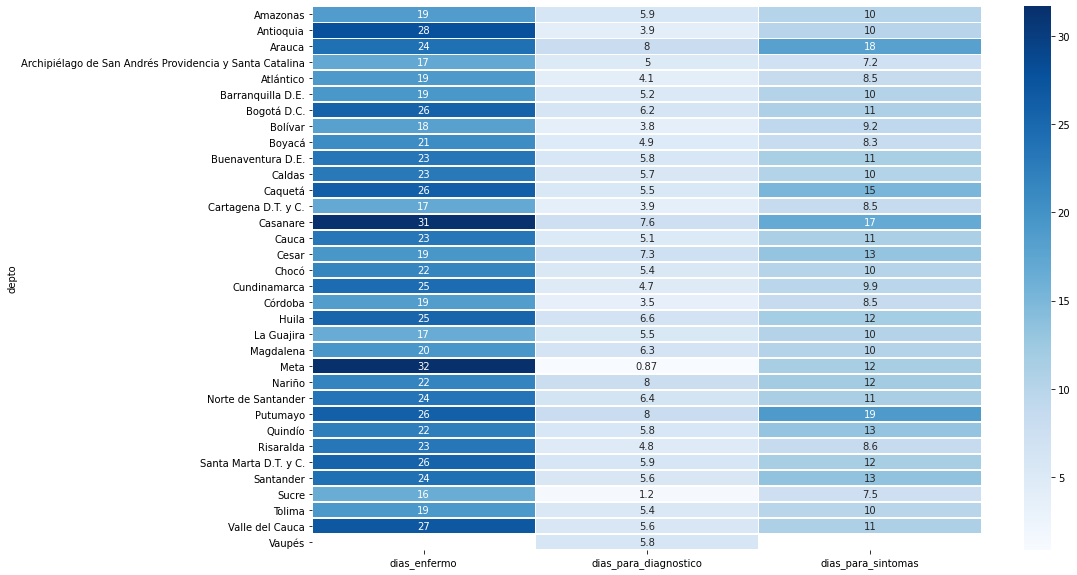

In [ ]:
PyPlot.figure(figsize=(15,10))
heatMapDias=SeaBorn.heatmap(diasPivot,xticklabels=diasPivot.columns,yticklabels=diasPivot.index,cmap="Blues",annot=True,linewidths=0.5)

Como hemos reducido el Dataset al promedio de los dias enfermo, días para diagnóstico y días para producir síntomas, estas tres variables se pueden graficar como puntos en tres dimensiones o por medio de un PairPlot.

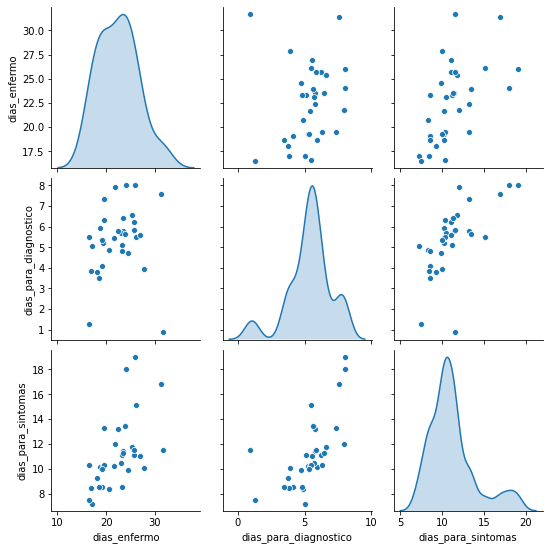

In [ ]:
SeaBorn.pairplot(diasPivot,diag_kind='kde')

Ahora, podemos clusterizar jerárquicamente este tabla pivote para generar un dendrograma, utilizando 

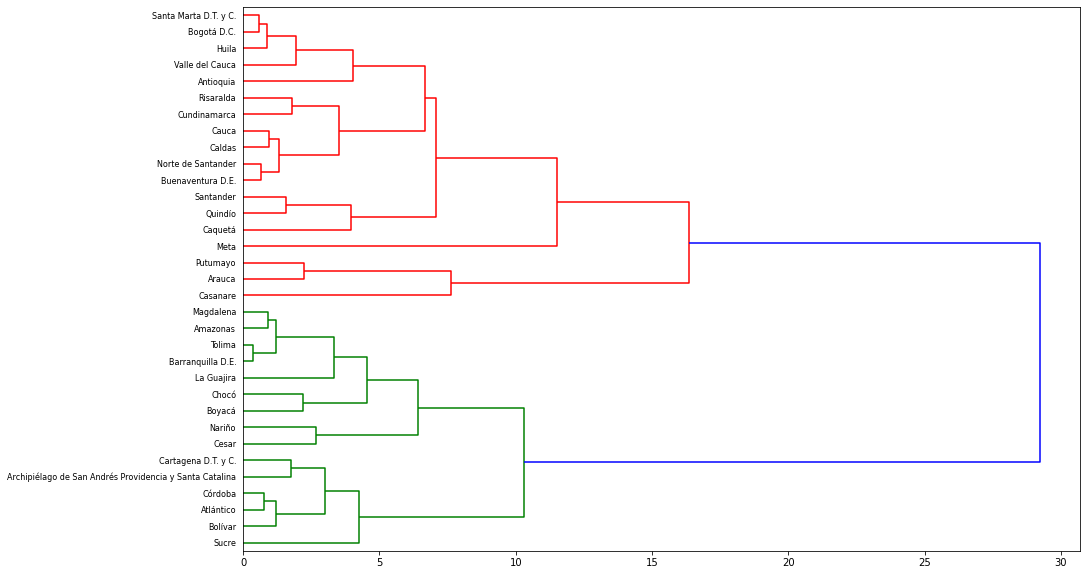

In [ ]:
from scipy.cluster.hierarchy import linkage,dendrogram
from scipy.spatial import distance_matrix
#creamos una matriz de distancias para ver la distancia punto a punto
#sacamos el departamento del vaupés porque tiene NaN
diasPivot = diasPivot.dropna()
conexionesCluster = linkage(diasPivot,'ward')

#creamos el dendrograma
PyPlot.figure(figsize=(15,10))
dendrogram(conexionesCluster,orientation='right',labels=diasPivot.index,show_leaf_counts=True)
PyPlot.show()

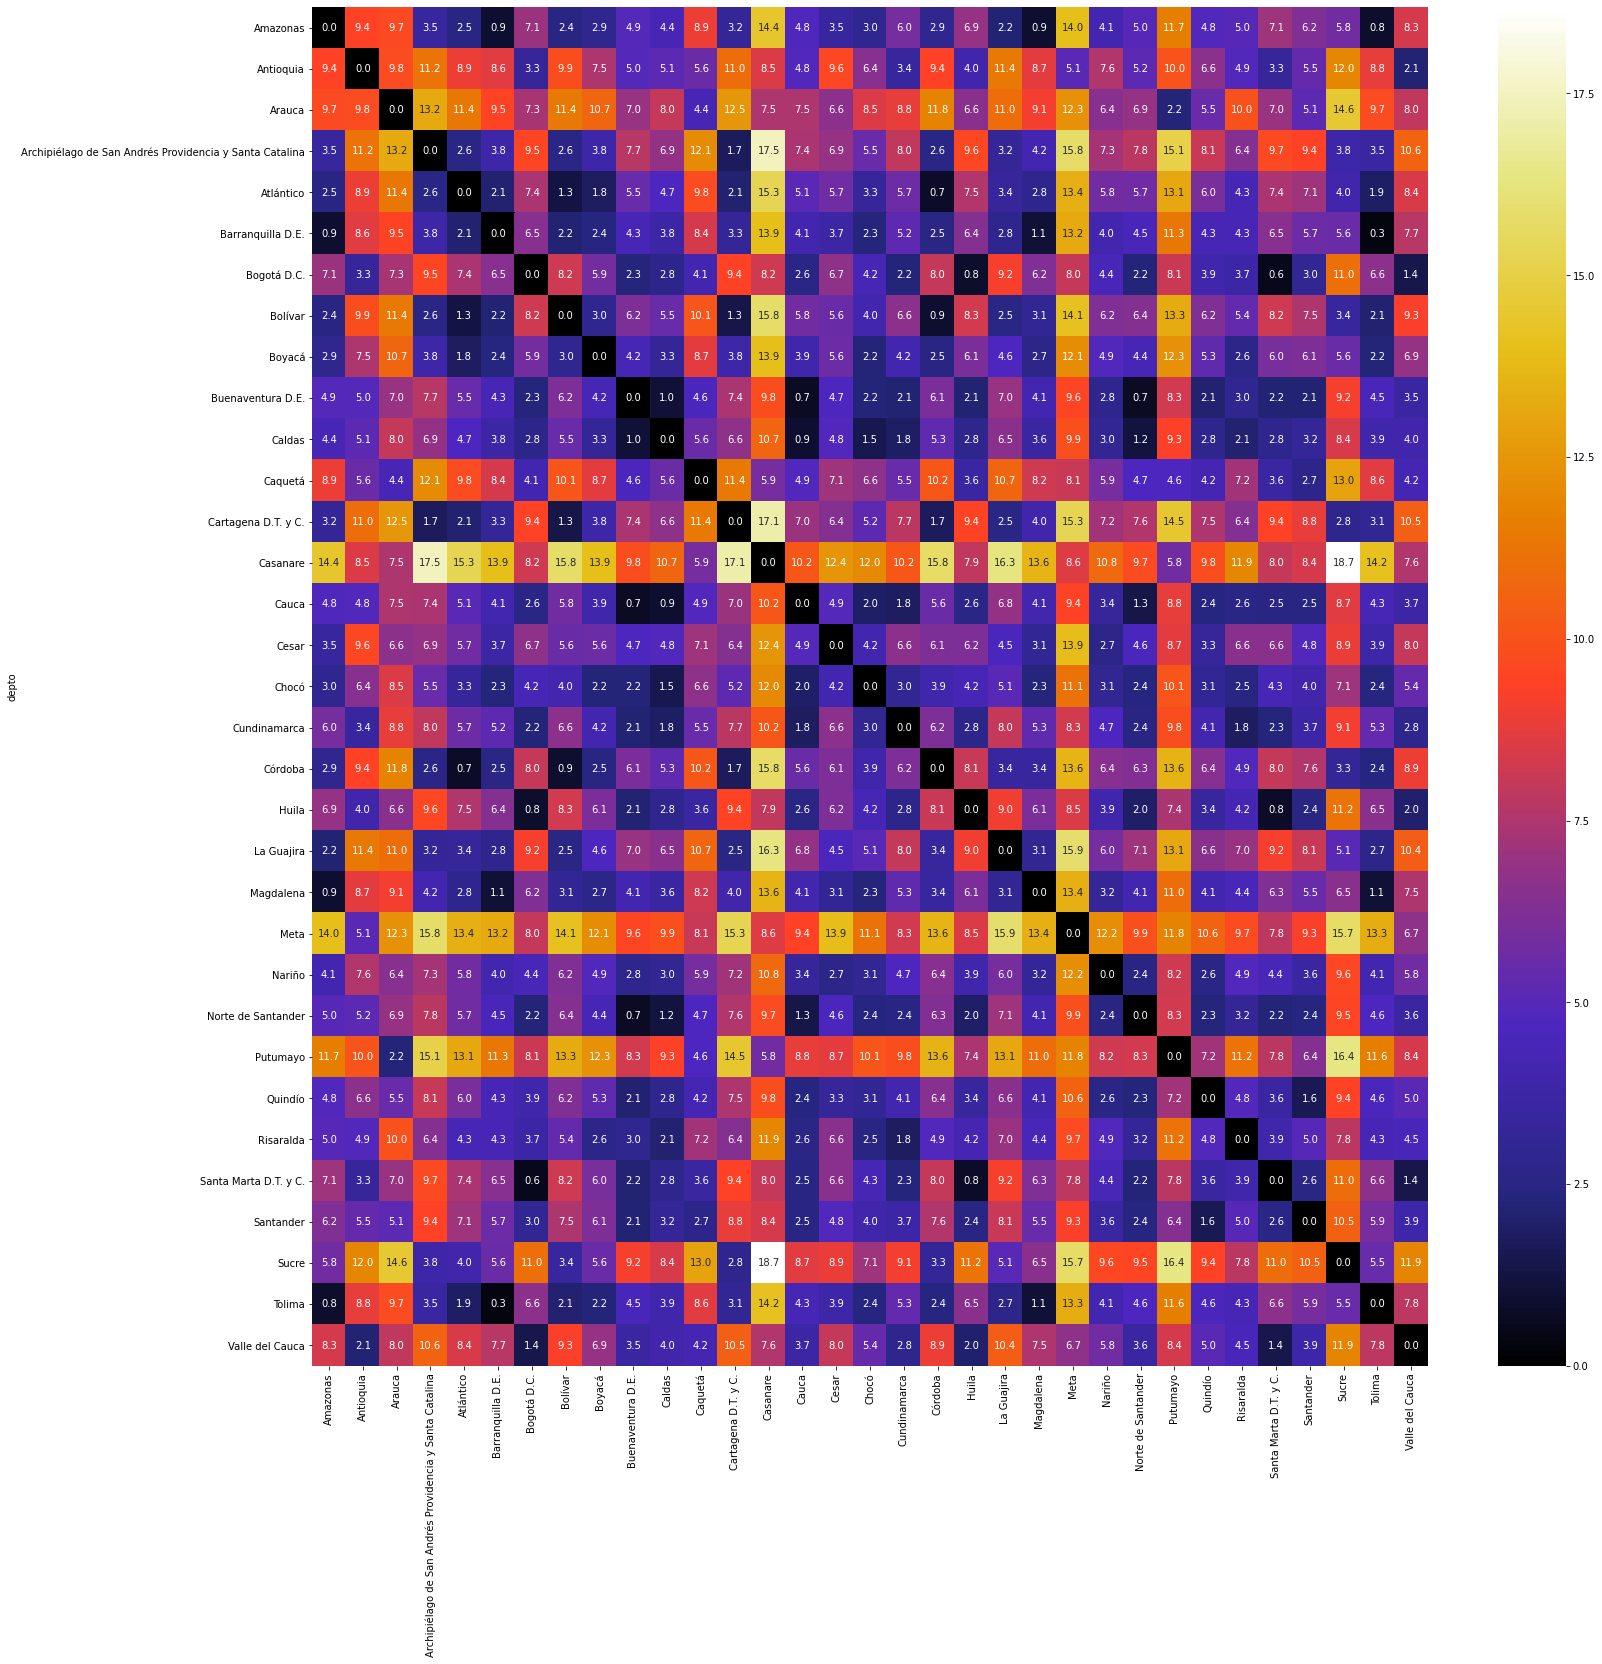

In [ ]:
distancias = Pandas.DataFrame(columns=['depto']+list(diasPivot.index))

for i1,row1 in diasPivot.iterrows():
  distanciasRow = {}
  distanciasRow['depto'] = i1
  for i2,row2 in diasPivot.iterrows():
    distanciasRow[i2] = ((row1['dias_enfermo']-row2['dias_enfermo'])**2+\
                        (row1['dias_para_diagnostico']-row2['dias_para_diagnostico'])**2+\
                        (row1['dias_para_sintomas']-row2['dias_para_sintomas'])**2)**0.5
  distancias = distancias.append(distanciasRow,ignore_index=True)

distancias = distancias.set_index('depto')
PyPlot.figure(figsize=(25,25))
heatMapDias=SeaBorn.heatmap(distancias,xticklabels=distancias.index,yticklabels=distancias.index,cmap="CMRmap",annot=True,fmt='.1f')